In [3]:
# import numpy and pandas, and DataFrame / Series
import math
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import scipy.optimize as optimize
import scipy
# Set some numpy options
np.set_printoptions(suppress=True)

# Set some pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# And some items for matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
#pd.options.display.mpl_style = 'default'

# read http://scikit-image.org/docs/dev/user_guide.html 
# for documentation
from skimage import io
from skimage import color

In [4]:
labels = pd.read_csv("../../02-logistic-regression/jupyter/kaggle/trainLabels.csv")
m  = labels["ID"].max()
print (m)


X = None
img_size = 32
for i in np.arange(1, m+1):
    img = color.rgb2gray (io.imread("../../02-logistic-regression/jupyter/kaggle/train/{0}.Bmp".format(i)))
    img32 = scipy.misc.imresize(img, (img_size,img_size))
    img32[img32<128] = 0
    img32[img32>=128] = 1
    img_array = np.array(img32).flatten()
    img_array = img_array.reshape(1, img_array.shape[0])
    if(X is None):
        X = img_array
    else:
        X = np.vstack((X, img_array))
    
    #X = np.concatenate(([X,img32.flatten(1)]), axis=0)
    
print(X.shape)

6283
(6283, 1024)


In [5]:
labels

        ID Class
0        1     n
1        2     8
2        3     T
3        4     I
4        5     R
5        6     W
6        7     L
7        8     l
8        9     K
9       10     G
10      11     A
11      12     A
12      13     C
13      14     u
14      15     t
15      16     A
16      17     N
17      18     I
18      19     O
19      20     k
20      21     l
21      22     D
22      23     T
23      24     u
24      25     w
25      26     N
26      27     E
27      28     E
28      29     H
29      30     e
30      31     C
31      32     A
32      33     N
33      34     T
34      35     C
35      36     A
36      37     W
37      38     i
38      39     O
39      40     r
40      41     a
41      42     0
42      43     a
43      44     N
44      45     H
45      46     e
46      47     R
47      48     1
48      49     A
49      50     6
50      51     o
51      52     L
52      53     H
53      54     A
54      55     0
55      56     W
56      57     1
57      58    

In [6]:
labels_s = labels["Class"].unique()
np.ndarray.sort(labels_s)
num_labels = labels_s.shape[0]
print(labels_s.shape[0])

62


In [7]:
y = np.ones((m,1))*-1
for i in np.arange(labels_s.shape[0]):
    have_true = labels["Class"]==labels_s[i]
    for j in np.arange(m):
        if(have_true[j] == True):
            y[j] = i

In [8]:
def displayData(X, example_width=None):
#DISPLAYDATA Display 2D data in a nice grid
#   [h, display_array] = DISPLAYDATA(X, example_width) displays 2D data
#   stored in X in a nice grid. It returns the figure handle h and the 
#   displayed array if requested.

    # Set example_width automatically if not passed in
    if example_width == None:
        example_width = round(math.sqrt(X.shape[1]));

    # Compute rows, cols
    m = X.shape[0]
    n = X.shape[1]
    example_height = round(n / example_width)
    
    # Compute number of items to display
    display_rows = math.floor(math.sqrt(m));
    display_cols = math.ceil(m / display_rows);

    # Between images padding
    pad = 1;
    
    # Setup blank display
    display_array = - np.ones((pad + (display_rows * (example_height + pad)), pad + (display_cols * (example_width + pad))))

    # Copy each example into a patch on the display array
    curr_ex = 0;
    for j in np.arange(display_rows):
        for i in np.arange(display_cols):
            if curr_ex > m : 
                break; 
            # Copy the patch

            # Get the max value of the patch
            max_val = np.amax(abs(X[curr_ex, :]));
            display_array_startx = j * (example_width + pad) #pad + (j * (example_height + pad)) - 1
            display_array_endx = ((j + 1) * (example_width + pad)) -1 # pad + (j * (example_height + pad))
            display_array_starty = i * (example_height + pad) # pad + (i * (example_width + pad))
            display_array_endy = ((i +1) * (example_height + pad)) - 1
                    
            de = (np.array(X[curr_ex, :]).reshape((example_width, example_height))) / max_val
            #print de.shape
            display_array[display_array_startx:display_array_endx, display_array_starty:display_array_endy] = (np.array(X[curr_ex, :]).reshape((example_width, example_height))) / max_val;
            curr_ex = curr_ex + 1;
        
        if curr_ex > m:
            break; 


    # Display Image
    plt.imshow(display_array, extent = [0,100,0,100], aspect='auto', cmap=plt.get_cmap('gray'))
    plt.show

In [9]:
#% Randomly select 100 data points to display
rand_indices=np.random.permutation(m)
sel = X[rand_indices[0:100], :]
print(sel.shape)

(100, 1024)


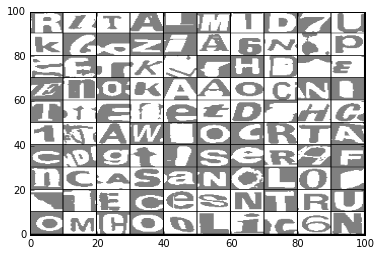

In [10]:
displayData(sel);

In [11]:
def sigmoid(z):
#SIGMOID Compute sigmoid functoon
#   J = SIGMOID(z) computes the sigmoid of z.
    
    g = 1.0 / (1.0 + np.exp(-z));
    return g

def sigmoidGradient(z):
#SIGMOID Compute sigmoid functoon
#   J = SIGMOID(z) computes the sigmoid of z.
    
    g  = sigmoid(z) * (1-sigmoid(z))
    return g

In [12]:
# See Lecture 51
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda):
    # %NNCOSTFUNCTION Implements the neural network cost function for a two layer
    # %neural network which performs classification
    # %   [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
    # %   X, y, lambda) computes the cost and gradient of the neural network. The
    # %   parameters for the neural network are "unrolled" into the vector
    # %   nn_params and need to be converted back into the weight matrices. 
    # % 
    # %   The returned parameter grad should be a "unrolled" vector of the
    # %   partial derivatives of the neural network.
    # %

    # % Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # % for our 2 layer neural network
    
    Theta1 = nn_params[0:hidden_layer_size*(input_layer_size+1)].reshape((hidden_layer_size, (input_layer_size+1)), order='F')
    # print(Theta1.shape)
    
    
    Theta2 = nn_params[hidden_layer_size*(input_layer_size+1):].reshape((num_labels, (hidden_layer_size+1)), order='F')
    # print(Theta2.shape)
    
    # Setup some useful variables
    m = X.shape[0]
    
    # You need to return the following variables correctly 
    J = 0;
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    # % ====================== YOUR CODE HERE ======================
    # % Instructions: You should complete the code by working through the
    # %               following parts.
    # %
    # % Part 1: Feedforward the neural network and return the cost in the
    # %         variable J. After implementing Part 1, you can verify that your
    # %         cost function computation is correct by verifying the cost
    # %         computed in ex4.m
    # %
    # % Part 2: Implement the backpropagation algorithm to compute the gradients
    # %         Theta1_grad and Theta2_grad. You should return the partial derivatives of
    # %         the cost function with respect to Theta1 and Theta2 in Theta1_grad and
    # %         Theta2_grad, respectively. After implementing Part 2, you can check
    # %         that your implementation is correct by running checkNNGradients
    # %
    # %         Note: The vector y passed into the function is a vector of labels
    # %               containing values from 1..K. You need to map this vector into a 
    # %               binary vector of 1's and 0's to be used with the neural network
    # %               cost function.
    # %
    # %         Hint: We recommend implementing backpropagation using a for-loop
    # %               over the training examples if you are implementing it for the 
    # %               first time.
    # %
    # % Part 3: Implement regularization with the cost function and gradients.
    # %
    # %         Hint: You can implement this around the code for
    # %               backpropagation. That is, you can compute the gradients for
    # %               the regularization separately and then add them to Theta1_grad
    # %               and Theta2_grad from Part 2.
    # %    
    
    a1 = np.hstack((np.ones((m,1)), X)) # (5000 x 401)
    z2 = a1.dot(Theta1.T)
    a2 = sigmoid(z2) # (5000 x 401) x (401 x 25) = 5000 x 25
    a2 = np.hstack((np.ones((a2.shape[0], 1)), a2)) # 5000 x 26    
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3) # (5000 x 26) x (26 x 10) = 5000 x 10
    h = a3
    
    # Explode y into 10 values with Y[i] := i == y.
    Y = np.zeros((m, num_labels)) # 5000 x 10
    for i in np.arange(m):
        Y[i, int(np.mod(y[i,0],num_labels))] = 1
    
    tmp = 1/m*np.sum(np.sum(-(Y*np.nan_to_num(np.log(h)))-(1-Y)*np.nan_to_num(np.log(1-h))))
    
    J_int = tmp + (lamda/(2*m))*np.sum(np.sum(Theta1[:, 1:] * Theta1[:, 1:])) 
    J = J_int + (lamda/(2*m))*np.sum(np.sum(Theta2[:, 1:] * Theta2[:, 1:])) 
    
    # 2. Backpropagate to get gradient information.
    s3 = h - Y;  # 5000 x 10
    s2 = sigmoidGradient(np.hstack((np.ones((z2.shape[0], 1)), z2))) # (5000 x 401) x (401 x 25) = 5000 x 25 +1 
    s2 = s3.dot(Theta2) * s2 # 5000 x 26

    # Vectorized ftw:
    Theta2_grad = (1/m) * s3.T.dot(a2) # ?? 10 x 26
    Theta1_grad = (1/m) * s2[:,1:].T.dot(a1) # ?? 25 x 5000 x 500 x 401 = 25 x 401
    
    p2 = (lamda/m) * np.hstack((np.zeros((Theta2.shape[0],1)), Theta2[:, 1:])) # (5000 x 401)    
    p1 = (lamda/m) * np.hstack((np.zeros((Theta1.shape[0],1)), Theta1[:, 1:])) # (5000 x 401)
 
    Grad2 = Theta2_grad + p2
    
    Grad1 = Theta1_grad + p1
    
    #  % Unroll gradients
    grad = np.hstack((Grad1.flatten(order='F'), Grad2.flatten(order='F')))
    
    return (J, grad)

In [13]:
# Setup the parameters you will use for this part of the exercise
input_layer_size  = 32*32;  # 32x32 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
#num_labels = 10;          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)

In [14]:
def randInitializeWeights(L_in, L_out):
# %RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
# %incoming connections and L_out outgoing connections
# %   W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights 
# %   of a layer with L_in incoming connections and L_out outgoing 
# %   connections. 
# %
# %   Note that W should be set to a matrix of size(L_out, 1 + L_in) as
# %   the first row of W handles the "bias" terms
# %
    
    epsilon_init = 0.12;
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init;
    
    return W


In [15]:
# %% ================ Part 6: Initializing Pameters ================
# %  In this part of the exercise, you will be starting to implment a two
# %  layer neural network that classifies digits. You will start by
# %  implementing a function to initialize the weights of the neural network
# %  (randInitializeWeights.m)

print('\nInitializing Neural Network Parameters ...\n')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size);
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels);

# % Unroll parameters
initial_nn_params = np.hstack((initial_Theta1.flatten(), initial_Theta2.flatten()))


Initializing Neural Network Parameters ...



In [16]:
#%% =================== Part 8: Training NN ===================
#%  You have now implemented all the code necessary to train a neural
#%  network. To train your neural network, we will now use "fmincg", which
#%  is a function which works similarly to "fminunc". Recall that these
#%  advanced optimizers are able to train our cost functions efficiently as
#%  long as we provide them with the gradient computations.
#%
print('\nTraining Neural Network... \n')

# %  After you have completed the assignment, change the MaxIter to a larger
# %  value to see how more training helps.
# options = optimset('MaxIter', 50);

# %  You should also try different values of lambda
lamda = 1;
 
options = {'maxiter': 1000}
# Try 'CG', 'BFGS', 'L-BFGS-B'
Result = optimize.minimize(fun = nnCostFunction, x0 = initial_nn_params, args = (input_layer_size, hidden_layer_size, num_labels, X, y, lamda), method = 'L-BFGS-B',
                                 #jac = lrCostGradFunction, options=options)
                                 jac=True, options=options)

nn_params = Result.x

if Result.success != True:
    print(Result.message)

# Obtain Theta1 and Theta2 back from nn_params
Theta1 = nn_params[0:hidden_layer_size*(input_layer_size+1)].reshape((hidden_layer_size, (input_layer_size+1)), order='F')
# print(Theta1.shape)
    
    
Theta2 = nn_params[hidden_layer_size*(input_layer_size+1):].reshape((num_labels, (hidden_layer_size+1)), order='F')

print('Program paused. Press enter to continue.\n');


Training Neural Network... 

Program paused. Press enter to continue.



In [17]:
def predict(Theta1, Theta2, X):
#%PREDICT Predict the label of an input given a trained neural network
#%   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
#%   trained weights of a neural network (Theta1, Theta2)

#% Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

#% You need to return the following variables correctly 
    p = np.zeros((m, 1))

    h1 = sigmoid(np.hstack((np.ones((m, 1)), X)).dot(Theta1.T))
    h2 = sigmoid(np.hstack((np.ones((m, 1)), h1)).dot(Theta2.T))
    
    
    p = np.argmax(h2, axis=1)

#% =========================================================================
    return p

In [20]:
# %% ================= Part 10: Implement Predict =================
# %  After training the neural network, we would like to use it to predict
# %  the labels. You will now implement the "predict" function to use the
# %  neural network to predict the labels of the training set. This lets
# %  you compute the training set accuracy.

pred = predict(Theta1, Theta2, X);

print("\nTraining Set Accuracy: {0}\n".format(np.mean(pred == (np.mod(y[:,0],num_labels))) * 100)) 


Training Set Accuracy: 77.39933152952412




Displaying Example Image


Neural Network Prediction: %d (digit %d)
 [21] 21.0


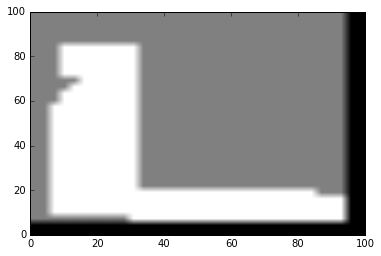

In [25]:
#%  To give you an idea of the network's output, you can also run
#%  through the examples one at the a time to see what it is predicting.

#%  Randomly permute examples
rp = np.random.permutation(m)
for i in np.arange(1):
    # % Display
    print('\nDisplaying Example Image\n');
    print
    sel2 = X[rp[i], :]
    displayData(sel2.reshape(1,sel2.shape[0]));

    pred = predict(Theta1, Theta2, sel2.reshape(1,sel2.shape[0]));
    print('\nNeural Network Prediction: %d (digit %d)\n', np.mod(pred,num_labels), np.mod(y[rp[i],0], num_labels))

## Write kaggle submission file

In [30]:
import glob

files_a = None
for file in glob.glob("../../02-logistic-regression/jupyter/kaggle/test/*.Bmp"):
    n_s= file.split('/')[6].split('.')[0]
    n = int(n_s)
    if(files_a is None):
        files_a = np.array(n)
    else:
        files_a = np.vstack((files_a, n))
        
np.ndarray.sort(files_a)       
files_a = files_a.flatten().tolist()

In [31]:
TEST = None
img_size = 32
for i in files_a:
    img = color.rgb2gray (io.imread("../../02-logistic-regression/jupyter/kaggle/test/{0}.Bmp".format(i)))
    img32 = scipy.misc.imresize(img, (img_size,img_size))
    img32[img32<128] = 0
    img32[img32>=128] = 1
    img_array = np.array(img32).flatten()
    img_array = img_array.reshape(1, img_array.shape[0])
    if(TEST is None):
        TEST = img_array
    else:
        TEST = np.vstack((TEST, img_array))

In [37]:
test_pred = predict(Theta1, Theta2, TEST);

In [38]:
print(TEST.shape)
print(test_pred.shape)
print(len(files_a))

(6220, 1024)
(6220,)
6220


In [39]:
d = {'Class' : test_pred.flatten(), 'ID' : files_a}

df = pd.DataFrame(d)

In [42]:
y_test = []

for i in files_a:
    y_test.append(labels_s[df[df["ID"]==i].Class.values[0]])
f = open("kaggle/test/submission.csv", 'w')

print(len(y_test))
j = 0
f.write("ID,Class\n")
for i in files_a:
    f.write("{0},{1}\n".format(i, y_test[j]))
    j = j+1
    
f.close()

f = open("kaggle/test/submission2.csv", 'w')
j = 0
f.write("ID,Class\n")
for i in files_a:
    f.write("{0},{1}\n".format(files_a[j], labels_s[test_pred[j]]))
    j = j+1
    
f.close()   

6220


## Sanity check for individual file

[10]
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
A


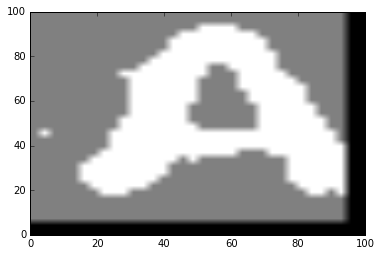

In [54]:
#delete
i = 9935

img = color.rgb2gray (io.imread("../../02-logistic-regression/jupyter/kaggle/test/{0}.Bmp".format(i)))
img32 = scipy.misc.imresize(img, (img_size,img_size))
img32[img32<128] = 0
img32[img32>=128] = 1
img_array = np.array(img32).flatten()
img_array = img_array.reshape(1, img_array.shape[0])

l_pred = predict(Theta1, Theta2, img_array);

print(l_pred)
print(labels_s)
print(labels_s[l_pred[0]])

displayData(img_array);
